# Twitter Sentiment Analysis

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install gensim --upgrade
!pip install tf-estimator-nightly==2.8.0.dev2021122109
!pip install keras==2.8.0 --upgrade
!pip install pandas --upgrade

     |████████████████████████████████| 24.1 MB 59.0 MB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0
     |████████████████████████████████| 462 kB 8.2 MB/s 


In [3]:
# DataFrame
import pandas as pd

# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# nltk
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

# Word2vec
import gensim

# Utility
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools

# Set log
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [4]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

### Settings

In [5]:
# DATASET
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
TRAIN_SIZE = 0.8

# TEXT CLENAING
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

# WORD2VEC 
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# KERAS
SEQUENCE_LENGTH = 300
EPOCHS = 8
BATCH_SIZE = 1024

# SENTIMENT
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = "NEUTRAL"
SENTIMENT_THRESHOLDS = (0.4, 0.7)

# EXPORT
KERAS_MODEL = "model.h5"
WORD2VEC_MODEL = "model.w2v"
TOKENIZER_MODEL = "tokenizer.pkl"
ENCODER_MODEL = "encoder.pkl"

### Read Dataset

### Dataset details
* **target**: the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive)
* **ids**: The id of the tweet ( 2087)
* **date**: the date of the tweet (Sat May 16 23:58:44 UTC 2009)
* **flag**: The query (lyx). If there is no query, then this value is NO_QUERY.
* **user**: the user that tweeted (robotickilldozr)
* **text**: the text of the tweet (Lyx is cool)

In [6]:
dataset_path = '/content/drive/MyDrive/Thac_sy/HK3/HTTM/BTL/training.1600000.processed.noemoticon.csv'
print("Open file:", dataset_path)
df = pd.read_csv(dataset_path, encoding =DATASET_ENCODING , names=DATASET_COLUMNS)

Open file: /content/drive/MyDrive/Thac_sy/HK3/HTTM/BTL/training.1600000.processed.noemoticon.csv


In [7]:
print("Dataset size:", len(df))

Dataset size: 1600000


In [8]:
df.head(5)

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


### Map target label to String
* **0** -> **NEGATIVE**
* **2** -> **NEUTRAL**
* **4** -> **POSITIVE**

In [7]:
decode_map = {0: "NEGATIVE", 2: "NEUTRAL", 4: "POSITIVE"}
def decode_sentiment(label):
    return decode_map[int(label)]

In [8]:
%%time
df.target = df.target.apply(lambda x: decode_sentiment(x))

CPU times: user 924 ms, sys: 19.7 ms, total: 944 ms
Wall time: 1.21 s


### Pre-Process dataset

In [10]:
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")

In [11]:
def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [12]:
%%time
df.text = df.text.apply(lambda x: preprocess(x))

CPU times: user 1min 10s, sys: 455 ms, total: 1min 11s
Wall time: 1min 19s


### Split train and test

In [13]:
df_train, df_test = train_test_split(df, test_size=1-TRAIN_SIZE, random_state=42)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

TRAIN size: 1280000
TEST size: 320000


### Word2Vec 

In [14]:
%%time
documents = [_text.split() for _text in df_train.text] 

CPU times: user 3.43 s, sys: 536 ms, total: 3.97 s
Wall time: 3.97 s


In [15]:
w2v_model = gensim.models.word2vec.Word2Vec(vector_size=W2V_SIZE, 
                                            window=W2V_WINDOW, 
                                            min_count=W2V_MIN_COUNT, 
                                            workers=8)

2022-05-18 13:28:20,243 : INFO : Word2Vec lifecycle event {'params': 'Word2Vec<vocab=0, vector_size=300, alpha=0.025>', 'datetime': '2022-05-18T13:28:20.242970', 'gensim': '4.2.0', 'python': '3.7.13 (default, Apr 24 2022, 01:04:09) \n[GCC 7.5.0]', 'platform': 'Linux-5.4.188+-x86_64-with-Ubuntu-18.04-bionic', 'event': 'created'}


In [16]:
w2v_model = gensim.models.word2vec.Word2Vec.load("/content/drive/MyDrive/Thac_sy/HK3/HTTM/BTL/model.w2v")

2022-05-18 13:28:20,253 : INFO : loading Word2Vec object from /content/drive/MyDrive/Thac_sy/HK3/HTTM/BTL/model.w2v
2022-05-18 13:28:22,273 : INFO : loading wv recursively from /content/drive/MyDrive/Thac_sy/HK3/HTTM/BTL/model.w2v.wv.* with mmap=None
2022-05-18 13:28:22,275 : INFO : setting ignored attribute cum_table to None
2022-05-18 13:28:22,643 : INFO : Word2Vec lifecycle event {'fname': '/content/drive/MyDrive/Thac_sy/HK3/HTTM/BTL/model.w2v', 'datetime': '2022-05-18T13:28:22.643621', 'gensim': '4.2.0', 'python': '3.7.13 (default, Apr 24 2022, 01:04:09) \n[GCC 7.5.0]', 'platform': 'Linux-5.4.188+-x86_64-with-Ubuntu-18.04-bionic', 'event': 'loaded'}


In [ ]:
w2v_model.build_vocab(documents)

In [ ]:
words = w2v_model.wv.key_to_index.keys()
vocab_size = len(words)
print("Vocab size", vocab_size)

In [ ]:
%%time
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

In [17]:
w2v_model.wv.most_similar("love")

[('luv', 0.5755597352981567),
 ('loves', 0.5569100379943848),
 ('loved', 0.5315336585044861),
 ('adore', 0.515910804271698),
 ('amazing', 0.5001928806304932),
 ('looove', 0.4803140163421631),
 ('awesome', 0.4583805203437805),
 ('loveee', 0.44891148805618286),
 ('loooove', 0.4446798264980316),
 ('lovee', 0.4409220218658447)]

In [20]:
w2v_model.save("model.w2v")

2022-05-18 05:16:25,701 : INFO : Word2Vec lifecycle event {'fname_or_handle': 'model.w2v', 'separately': 'None', 'sep_limit': 10485760, 'ignore': frozenset(), 'datetime': '2022-05-18T05:16:25.701123', 'gensim': '4.2.0', 'python': '3.7.13 (default, Apr 24 2022, 01:04:09) \n[GCC 7.5.0]', 'platform': 'Linux-5.4.188+-x86_64-with-Ubuntu-18.04-bionic', 'event': 'saving'}
2022-05-18 05:16:25,703 : INFO : not storing attribute cum_table
2022-05-18 05:16:25,871 : INFO : saved model.w2v


### Tokenize Text

In [18]:
%%time
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.text)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 290419
CPU times: user 21.5 s, sys: 271 ms, total: 21.8 s
Wall time: 22.4 s


In [19]:
%%time
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.text), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.text), maxlen=SEQUENCE_LENGTH)

CPU times: user 27.7 s, sys: 945 ms, total: 28.6 s
Wall time: 28.7 s


### Label Encoder 

In [20]:
labels = df_train.target.unique().tolist()
labels.append(NEUTRAL)
labels

['POSITIVE', 'NEGATIVE', 'NEUTRAL']

In [21]:
encoder = LabelEncoder()
encoder.fit(df_train.target.tolist())

y_train = encoder.transform(df_train.target.tolist())
y_test = encoder.transform(df_test.target.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (1280000, 1)
y_test (320000, 1)


In [22]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print()
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (1280000, 300)
y_train (1280000, 1)

x_test (320000, 300)
y_test (320000, 1)


In [25]:
y_train[:10]

array([[1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1]])

### Embedding layer

In [23]:
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(290419, 300)


In [24]:
embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)

### Build Model

In [25]:
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 300)          87125700  
                                                                 
 dropout (Dropout)           (None, 300, 300)          0         
                                                                 
 lstm (LSTM)                 (None, 100)               160400    
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 87,286,201
Trainable params: 160,501
Non-trainable params: 87,125,700
_________________________________________________________________


### Compile model

In [26]:
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

### Callbacks

In [27]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)]

### Train

In [28]:
import tensorflow as tf
from tensorflow import keras
model = keras.models.load_model("/content/drive/MyDrive/Thac_sy/HK3/HTTM/BTL/model.h5")

In [ ]:
%%time
history = model.fit(x_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

In [ ]:
import matplotlib.pyplot as plt
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

### Evaluate

In [29]:
%%time
score = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

313/313 [==============================] - 903s 3s/step - loss: 0.4443 - accuracy: 0.7911

ACCURACY: 0.7911343574523926
LOSS: 0.44429534673690796
CPU times: user 25min 51s, sys: 1min 51s, total: 27min 43s
Wall time: 15min 22s


In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

### Predict

In [30]:
def decode_sentiment(score, include_neutral=True):
    if include_neutral:        
        label = NEUTRAL
        if score <= SENTIMENT_THRESHOLDS[0]:
            label = NEGATIVE
        elif score >= SENTIMENT_THRESHOLDS[1]:
            label = POSITIVE

        return label
    else:
        return NEGATIVE if score < 0.5 else POSITIVE

In [31]:
def predict(text, include_neutral=True):
    start_at = time.time()
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=SEQUENCE_LENGTH)
    # Predict
    score = model.predict([x_test])[0]
    # Decode sentiment
    label = decode_sentiment(score, include_neutral=include_neutral)

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at}  

In [32]:
predict("I love the music")

{'elapsed_time': 0.6728115081787109,
 'label': 'POSITIVE',
 'score': 0.9656286239624023}

In [33]:
predict("I hate the rain")

{'elapsed_time': 0.13213443756103516,
 'label': 'NEGATIVE',
 'score': 0.01075369119644165}

In [34]:
predict("i don't know what i'm doing")

{'elapsed_time': 0.128692626953125,
 'label': 'NEGATIVE',
 'score': 0.2742375135421753}

### Confusion Matrix

In [35]:
%%time
y_pred_1d = []
y_test_1d = list(df_test.target)
scores = model.predict(x_test, verbose=1, batch_size=8000)
y_pred_1d = [decode_sentiment(score, include_neutral=False) for score in scores]

40/40 [==============================] - 1070s 27s/step
CPU times: user 25min 35s, sys: 8min 18s, total: 33min 54s
Wall time: 17min 50s


In [36]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

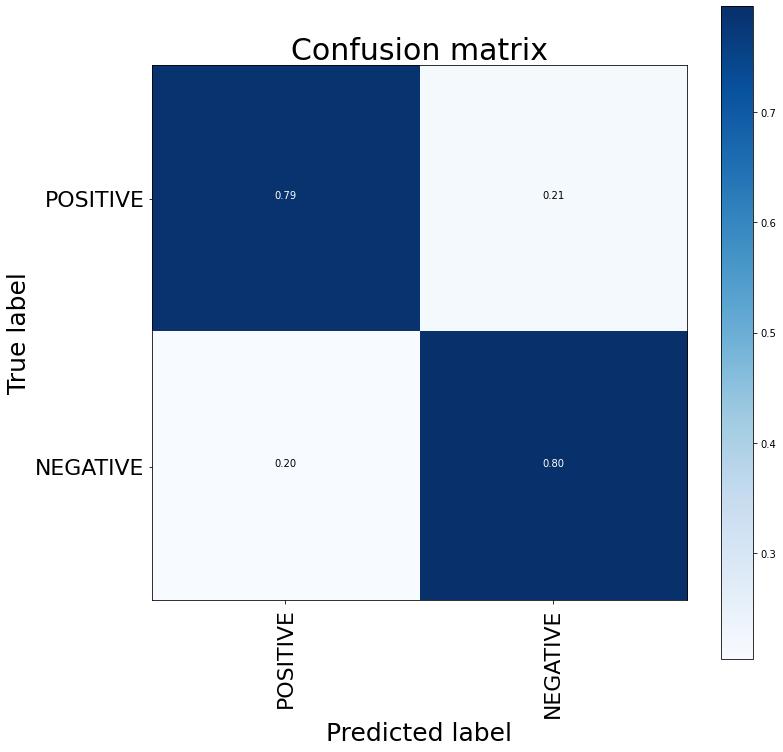

CPU times: user 1.59 s, sys: 59.1 ms, total: 1.65 s
Wall time: 1.79 s


In [37]:
%%time

cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cnf_matrix, classes=df_train.target.unique(), title="Confusion matrix")
plt.show()

### Classification Report

In [38]:
print(classification_report(y_test_1d, y_pred_1d))

              precision    recall  f1-score   support

    NEGATIVE       0.79      0.79      0.79    159494
    POSITIVE       0.79      0.80      0.79    160506

    accuracy                           0.79    320000
   macro avg       0.79      0.79      0.79    320000
weighted avg       0.79      0.79      0.79    320000



### Accuracy Score

In [39]:
accuracy_score(y_test_1d, y_pred_1d)

0.791134375

### Save model

In [ ]:
model.save(KERAS_MODEL)
w2v_model.save(WORD2VEC_MODEL)
pickle.dump(tokenizer, open(TOKENIZER_MODEL, "wb"), protocol=0)
pickle.dump(encoder, open(ENCODER_MODEL, "wb"), protocol=0)

In [ ]:
#!cp "model.w2v" "/content/drive/MyDrive/Thac_sy/HK3/HTTM/BTL/"

In [ ]:
#!cp "model.h5" "/content/drive/MyDrive/Thac_sy/HK3/HTTM/BTL/"

In [ ]:
#!cp "tokenizer.pkl" "/content/drive/MyDrive/Thac_sy/HK3/HTTM/BTL/"

In [ ]:
#!cp "encoder.pkl" "/content/drive/MyDrive/Thac_sy/HK3/HTTM/BTL/"